In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
import time
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

In [2]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])


def contactMatrix(t):   
    return C

# duration of simulation and data file
Tf = 100;  
Nt=Tf+1; 

beta = 0.02
alpha = np.array([0.5, 0.2])
gIa = 1/7 
gIs = 1/7 
fsa = 1


# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']

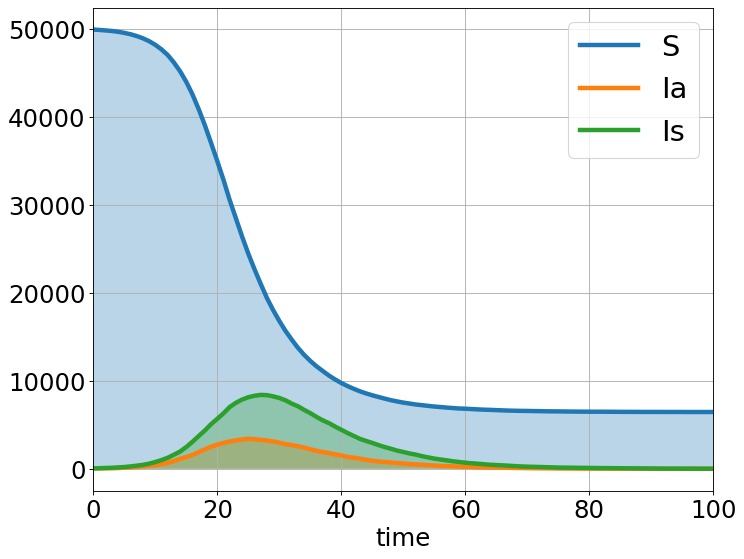

In [3]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1
x = (data_array[:Nf_inference]).astype('float')

In [5]:
inference_parameters = {
    'betaIa' : beta*alpha, 
    'betaIs' : beta*(1-alpha), 
    'gIa' : gIa, 
    'gIs' : gIs
}

model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"]]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}

In [6]:
# a filter that sums over all the infected people for each age group
fltr = np.kron([0, 1, 1],np.identity(M))
print(fltr)

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# initialise the estimator 
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, Ni, lyapunov_method='euler')
estimator.set_det_method('LSODA', rtol=1e-6)

# compute -log_p for the original (correct) parameters 
logp = estimator.minus_logp_red(inference_parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)
print(logp) 

[[0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]]
171.48952573435804


In [7]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4
param_priors = {
    'betaIa':{
        'mean': beta*alpha, 
        'std': [0.002]*2, 
        'bounds': [[eps, 0.1]]*2
    }, 
    'betaIs':{
        'mean': beta*(1-alpha), 
        'std': [0.02]*2,
        'bounds': [[eps, 0.1]]*2
    }, 
    'gIa':{
        'mean': 0.15, 
        'std': 0.1,
        'bounds': [eps, 0.6]
    }, 
    'gIs':{
        'mean': 0.15,
        'std': 0.1, 
        'bounds': [eps, 0.6]
    }
}

In [8]:
Ia0_g = (Ia0)
Ia0_std = Ia0_g
Ia0_b = np.array([[0.1, 100]]*M)

S0_g = (S0)
S0_std = Ia0_std*3
S0_b = [(100, N) for N in Ni]

init_priors = {
    'independent':{
        'fltr': np.repeat([True, True, False], M), 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S0_std, *Ia0_std], 
        'bounds': [*S0_b, *Ia0_b]
    }
}

# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)



start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors,
                                    use_gradient=True, tangent=True, global_max_iter=20, global_atol=10, 
                                    enable_global=True, verbose=True, ftol=ftol, local_max_iter=10000) 
end_time = time.time() 
print(end_time-start_time)
print('log_likelihood', res['log_likelihood'])
print('log_posterior', res['log_posterior'])

Looking for saved derivative functions...
Loaded.
Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=2712809251, Tue Jul 21 17:39:47 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 8.006657090577901e+02 1.0e+00 1.01e+00  2e-03  6e+01 0:00.2
    2     32 1.782019624073900e+02 1.3e+00 1.02e+00  2e-03  6e+01 0:00.3
    3     48 2.265736876348951e+02 1.4e+00 9.63e-01  2e-03  6e+01 0:00.4
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  178.20196240739003
Starting local minimisation...
Optimal value (local minimisation):  166.10614805541215
11.108118057250977
log_likelihood -169.8662946621752
log_posterior -166.10614805541215


In [9]:
# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)  
start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors,
                                    use_gradient=False, tangent=True, global_max_iter=30, global_atol=10, 
                                    enable_global=True, verbose=True, ftol=ftol, local_max_iter=1000) 
end_time = time.time()
print(end_time-start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=93726092, Tue Jul 21 15:36:16 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.028508442933303e+03 1.0e+00 9.47e-01  2e-03  6e+01 0:00.2
    2     32 4.373194611644797e+02 1.2e+00 9.04e-01  2e-03  5e+01 0:00.3
    3     48 3.649130972751703e+02 1.2e+00 8.38e-01  2e-03  5e+01 0:00.4
   28    448 1.760244047023997e+02 4.6e+00 3.50e-01  7e-04  2e+01 0:03.5
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  163.93471513512
Starting local minimisation...
Optimal value (local minimisation):  163.26356087680477
4.139167070388794


In [9]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = res['map_params_dict']
print(best_estimates)

print(res['map_x0'].astype('int'))

print('log_posterior', res['log_posterior'])

print('log_likelihood', res['log_likelihood'])

True parameters:
{'betaIa': array([0.01 , 0.004]), 'betaIs': array([0.01 , 0.016]), 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285}

Inferred parameters:
{'betaIa': array([0.0099357 , 0.00304121]), 'betaIs': array([0.01063686, 0.01730787]), 'gIa': 0.14507305447900348, 'gIs': 0.1547150840384477}
[12476 37463     7     7    32    32]
log_posterior -166.10614805541215
log_likelihood -169.8662946621752


(10, 2)


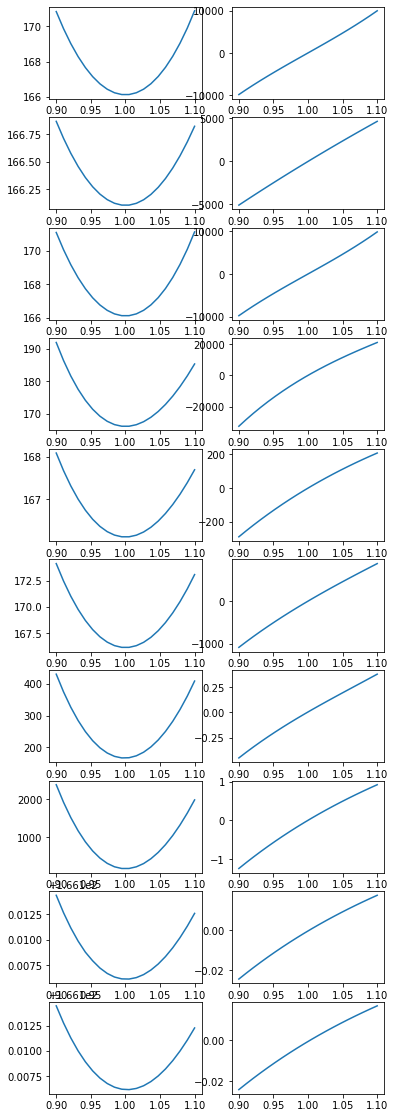

In [14]:
flat_maps = res['flat_map'].copy() 
h = len(flat_maps) 
plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(h, 2, figsize=(6, 2*h))
print(axs.shape)

for index in range(h):

    scales = np.linspace(0.9, 1.1, 20)
    flat_maps = res['flat_map'].copy() 
    central_val = flat_maps[index]

    f = np.empty((len(scales)))
    df = np.empty((len(scales), len(flat_maps)))
    for (i, val) in enumerate(central_val*scales): 
        flat_maps[index] = val 
        a, b = estimator._eval_posterior(flat_maps, obs, fltr, Tf_inference, contactMatrix, res,
                            tangent=True, use_gradient=True)
        f[i] = a 
        df[i] = b 

    axs[index, 0].plot(scales, f)
    axs[index, 1].plot(scales, df[:, index])
    
plt.show() 

In [12]:
flat_map = res['flat_map']
param_length = res['param_length']
a_step = 1e-5*flat_map
a_step[param_length:] = 1e-2

start_time = time.time() 
hessian = estimator.compute_hessian_latent(obs, fltr, Tf_inference, contactMatrix, res,
                                    tangent=True, a_step=a_step, use_gradient=True,
                                    fd_method="central")
end_time = time.time() 
print(np.linalg.eigh(hessian)[0])
print(end_time - start_time)

[2.71991812e-04 2.77730110e-04 2.78489961e-02 2.94392874e-02
 6.08981155e+02 1.07658184e+04 1.15240922e+05 2.18748725e+05
 1.73476989e+07 3.06689941e+07]
1.8600730895996094


In [13]:
start_time = time.time() 
hessian = estimator.compute_hessian_latent(obs, fltr, Tf_inference, contactMatrix, res,
                                    tangent=True, a_step=a_step, use_gradient=False,
                                    fd_method="central")
end_time = time.time() 
print(np.linalg.eigh(hessian)[0])
print(end_time-start_time) 

[2.76801579e-04 2.77691464e-04 2.78358755e-02 2.93877283e-02
 6.08289354e+02 1.07645747e+04 1.15123681e+05 2.17859935e+05
 1.73395940e+07 3.06656961e+07]
2.402580976486206


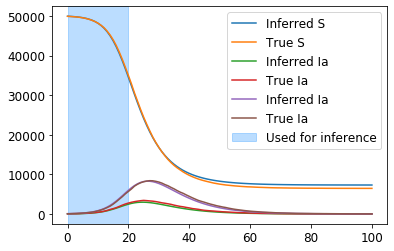

In [15]:
Nf = 101
Tf = Nf-1

map_x0 = res['map_x0']

estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
x_det = estimator.integrate(map_x0, 0, Tf, Nf)
x = data['X']
plt.rcParams.update({'font.size': 12})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Ia')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 